In [255]:
import pandas as pd


hydrotorax_df = pd.read_csv('Гидроторакс.csv').set_index('ID Файла')
hearth_df = pd.read_csv('Очаг.csv').set_index('ID Файла')
pneureduce_df = pd.read_csv('Снижение пневматизации.csv').set_index('ID Файла')


In [257]:
# Рассчет усредненной разметки для каждого случая
pneureduce_df.loc['Средняя разметка'] = pneureduce_df.mean(axis=0)
hearth_df.loc['Средняя разметка'] = hearth_df.mean(axis=0)
hydrotorax_df.loc['Средняя разметка'] = hydrotorax_df.mean(axis=0)

# Вывод первых строк для проверки
pneureduce_df.loc['Средняя разметка'].head(), hearth_df.loc['Средняя разметка'].head(), hydrotorax_df.loc['Средняя разметка'].head()


(Врач№1    0.150943
 Врач№2    0.081761
 Врач№3    0.106918
 Врач№4    0.138365
 Врач№5    0.134172
 Name: Средняя разметка, dtype: float64,
 Врач№1    0.104822
 Врач№2    0.236897
 Врач№3    0.054507
 Врач№4    0.121593
 Врач№5    0.056604
 Name: Средняя разметка, dtype: float64,
 Врач№1    0.119497
 Врач№2    0.255765
 Врач№3    0.052411
 Врач№4    0.197065
 Врач№5    0.167715
 Name: Средняя разметка, dtype: float64)

**Оценить качество разметки каждого врача по каждой патологии**

будем сравнивать как среднее отклонение от усредненной по всем врачам разметке

In [259]:
import numpy as np
import matplotlib.pyplot as plt
from scipy. stats import norm

# Вычисление среднего и стандартного отклонения для каждой строки "Средняя разметка"
mean_pnrd = pneureduce_df.loc['Средняя разметка'].mean()
std_pnrd = pneureduce_df.loc['Средняя разметка'].std()

mean_hearth = hearth_df.loc['Средняя разметка'].mean()
std_hearth = hearth_df.loc['Средняя разметка'].std()

mean_hydrotorax = hydrotorax_df.loc['Средняя разметка'].mean()
std_hydrotorax = hydrotorax_df.loc['Средняя разметка'].std()

# Вычисляем стандартную ошибку для каждого врача
std_err_pnrd = (pneureduce_df.loc['Средняя разметка'] - mean_pnrd) / std_pnrd
std_err_hearth = (hearth_df.loc['Средняя разметка'] - mean_hearth) / std_hearth
std_err_hydrotorax = (hydrotorax_df.loc['Средняя разметка'] - mean_hydrotorax) / std_hydrotorax

In [227]:
std_err_hearth

Врач№1    -0.177095
Врач№2     1.703296
Врач№3    -0.893435
Врач№4     0.061685
Врач№5    -0.863587
Врач№6     0.688482
Врач№7     0.121380
Врач№8    -0.803892
Врач№9    -0.535265
Врач№10   -0.236790
Врач№11   -0.684502
Врач№12    0.419855
Врач№13   -0.833740
Врач№14   -0.505417
Врач№15    2.539026
Name: Средняя разметка, dtype: float64

Далее, я иллюстрирую нормальное распределение для каждого врача и **считаю ошибчивыми тех врачей, стандартная ошибка которых, не входит в 90й перцентиль**

90й перцентиль это 1.28 стандартных отклонений

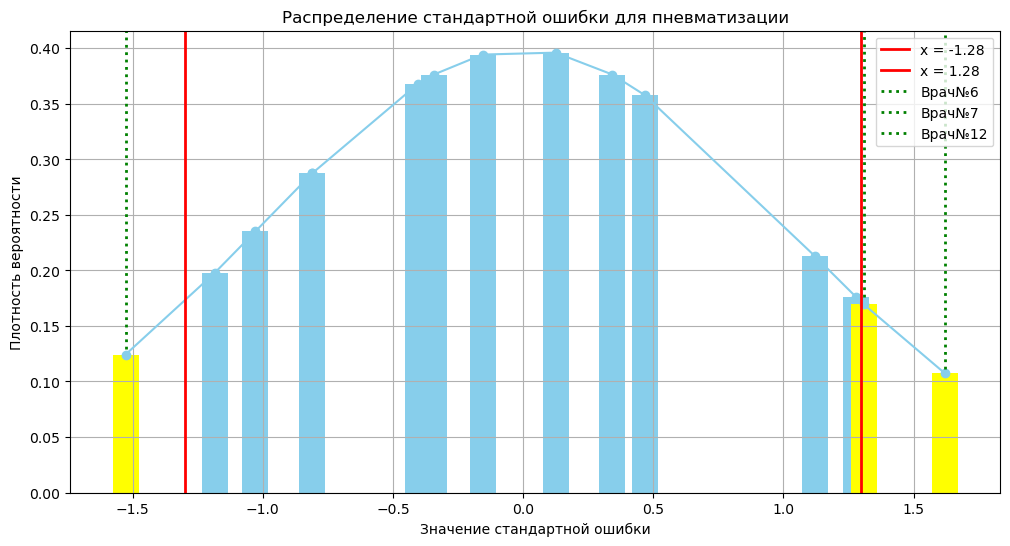

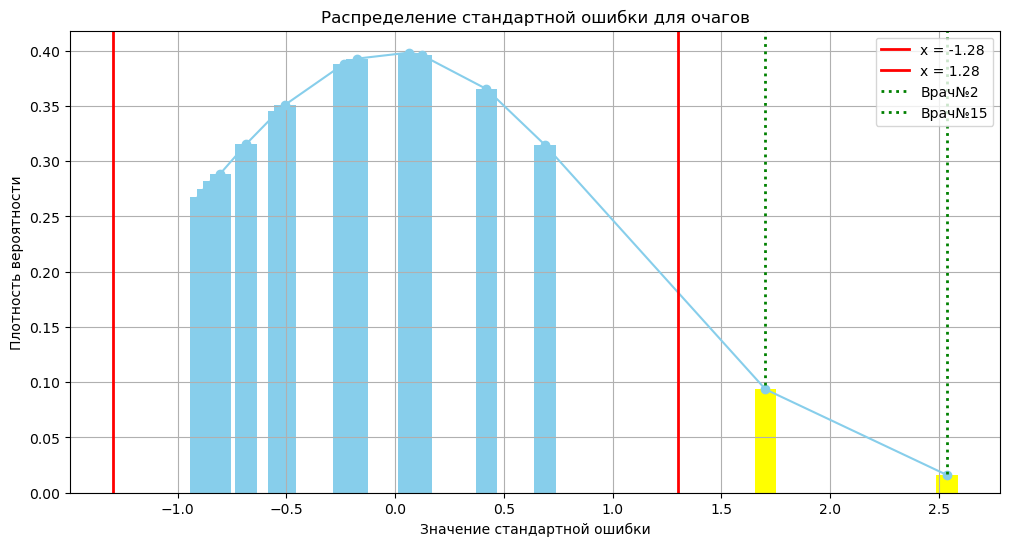

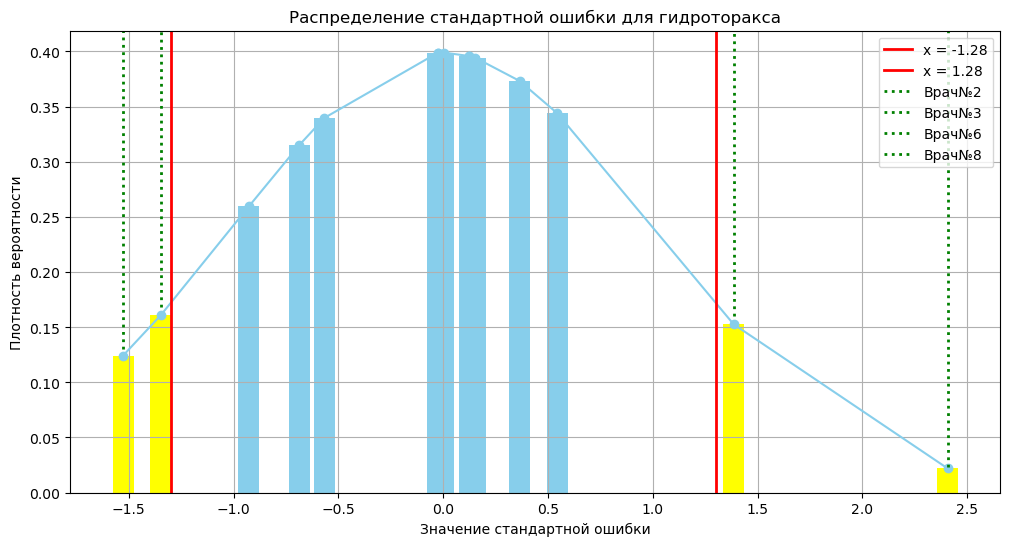

In [261]:
# Расчет нормального распределения для каждого значения x

def graphick(values, titlee):
    # Получаем отсортированные значения стандартной ошибки
    x_values = np.array(sorted(values.values()))
    y_values = norm.pdf(x_values)  # Вычисляем значения плотности вероятности для каждой ошибки

    plt.figure(figsize=(12, 6))
    plt.plot(x_values, y_values, 'o-', color='skyblue')  # Используем точечный график для наглядности
    plt.bar(x_values, y_values, width=0.1, color='skyblue', edgecolor='none')
    plt.axvline(x=-1.3, color='red',  linewidth=2, label='x = -1.28')
    plt.axvline(x=1.3, color='red',  linewidth=2, label='x = 1.28')
    
    # Помечаем каждую позицию врача на графике
    for label, x_val in values.items():
        if x_val > 1.28 or x_val < -1.28:
            y_val = norm.pdf(x_val)
            plt.bar(x_val, y_val, width=0.1, color='yellow', edgecolor='none')

            plt.axvline(x=x_val,ymin=y_val*2.5, color='green', linestyle='dotted', linewidth=2, label=label)

    plt.title(titlee)
    plt.xlabel("Значение стандартной ошибки")
    plt.ylabel("Плотность вероятности")
    plt.legend()
    plt.grid(True)
    plt.show()

    

graphick(dict(std_err_pnrd), "Распределение стандартной ошибки для пневматизации")
graphick(dict(std_err_hearth), "Распределение стандартной ошибки для очагов")
graphick(dict(std_err_hydrotorax), "Распределение стандартной ошибки для гидроторакса")

**Итоговая разметка**
критерий уверенности: **среднее значение по врачам на снимок**


In [263]:
# Рассчет усредненной разметки для каждого случая
hydrotorax_mean = hydrotorax_df.mean(axis=1)
hearth_mean = hearth_df.mean(axis=1)
pneureduce_mean = pneureduce_df.mean(axis=1)

# Итоговая разметка (бинарная) на основе усредненной разметки
hydrotorax_final = (hydrotorax_mean >= 0.5).astype(int)
hearth_final = (hearth_mean >= 0.5).astype(int)
pneureduce_final = (pneureduce_mean >= 0.5).astype(int)

# Уверенность в разметке 
def calculate_confidence(df, final_annotations):
    confidence = []
    for index, row in df.iterrows():
        if final_annotations.loc[index] == 1:
            confidence.append(round(row.mean(), 2))
        else:
            confidence.append(round(1 - row.mean(), 2))
    return confidence

hydrotorax_confidence = calculate_confidence(hydrotorax_df, hydrotorax_final)
hearth_confidence = calculate_confidence(hearth_df, hearth_final)
pneureduce_confidence = calculate_confidence(pneureduce_df, pneureduce_final)

final_df = pd.DataFrame({
    'Гидроторакс Итог': hydrotorax_final,
    'Гидроторакс Уверенность': hydrotorax_confidence,
    'Очаг Итог': hearth_final,
    'Очаг Уверенность': hearth_confidence,
    'Снижение Пневматизации Итог': pneureduce_final,
    'Снижение Пневматизации Уверенность': pneureduce_confidence
})


final_df

,Гидроторакс Итог,Гидроторакс Уверенность,Очаг Итог,Очаг Уверенность,Снижение Пневматизации Итог,Снижение Пневматизации Уверенность
ID Файла,,,,,,
0,1,0.73,0,0.87,0,0.73
1,0,0.87,0,1.00,0,0.93
2,0,0.67,0,0.93,0,0.93
3,0,0.60,0,1.00,0,1.00
4,0,1.00,0,0.80,0,0.80
...,...,...,...,...,...,...
473,1,0.53,0,0.73,0,0.80
474,0,0.60,0,1.00,0,1.00
475,1,0.80,0,1.00,0,1.00


**Среднее значение уверенности:**

Это будет средняя доля врачей, согласных с итоговой разметкой.
Чем выше это значение, тем больше согласие между врачами, и, следовательно, тем выше качество разметки.

**Стандартное отклонение уверенности:**

Это будет показывать вариативность в уверенности врачей.
Низкое значение стандартного отклонения указывает на то, что большинство врачей имеют схожие мнения.

**Средняя ковариация:**

Мы можем рассчитать среднюю ковариацию разметок между врачами,
чтобы понять, насколько согласованно работают врачи.

In [279]:
import statistics
# Стандартное отклонение уверенности
std_confidence_hydrotorax = pd.DataFrame(hydrotorax_confidence).std()
std_confidence_hydrotorax = float(std_confidence_hydrotorax.iloc[0])
std_confidence_hearth = pd.DataFrame(hearth_confidence).std()
std_confidence_hearth = float(std_confidence_hearth.iloc[0])
std_confidence_pneureduce = pd.DataFrame(pneureduce_confidence).std()
std_confidence_pneureduce = float(std_confidence_pneureduce.iloc[0])


# Ковариационная матрица разметок врачей для каждой патологии
cov_matrix_hydrotorax = hydrotorax_df.cov()
cov_matrix_hearth = hearth_df.cov()
cov_matrix_pneureduce = pneureduce_df.cov()

# Средняя ковариация
mean_cov_hydrotorax = cov_matrix_hydrotorax.mean().mean()
mean_cov_hearth = cov_matrix_hearth.mean().mean()
mean_cov_pneureduce = cov_matrix_pneureduce.mean().mean()

# Формирование результатов
print(statistics.mean(hydrotorax_confidence))
total_hyd_conf = statistics.mean(hydrotorax_confidence)
total_hearth_conf = statistics.mean(hearth_confidence)
total_pneureduce_conf = statistics.mean(pneureduce_confidence)



results = {
    'Патология': ['Гидроторакс', 'Очаг', 'Снижение Пневматизации'],
    'Средняя Уверенность': [total_hyd_conf, total_hearth_conf, total_pneureduce_conf],
    'Стандартное Отклонение Уверенности': [std_confidence_hydrotorax, std_confidence_hearth, std_confidence_pneureduce],
    'Средняя Ковариация': [mean_cov_hydrotorax, mean_cov_hearth, mean_cov_pneureduce]
}

results_df = pd.DataFrame(results)

results_df


0.912489539748954


,Патология,Средняя Уверенность,Стандартное Отклонение Уверенности,Средняя Ковариация
0,Гидроторакс,0.912490,0.130963,0.071512
1,Очаг,0.900502,0.132915,0.031934
2,Снижение Пневматизации,0.880900,0.147250,0.052367
